In [ ]:
!apt-get install poppler-utils 

In [17]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain==0.0.173 --progress-bar off
!pip install -qqq chromadb==0.3.23 --progress-bar off
!pip install -qqq pypdf==3.8.1 --progress-bar off
!pip install -qqq pygpt4all==1.1.0 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

In [2]:
!gdown 1DpFisoGXsQbpQJvijuvxkLW_pg-FUUMF

Downloading...
From: https://drive.google.com/uc?id=1DpFisoGXsQbpQJvijuvxkLW_pg-FUUMF
To: /content/ms-financial-statement.pdf
100% 29.1k/29.1k [00:00<00:00, 75.4MB/s]


In [3]:
!wget https://gpt4all.io/models/ggml-gpt4all-j-v1.3-groovy.bin

--2023-05-20 07:41:01--  https://gpt4all.io/models/ggml-gpt4all-j-v1.3-groovy.bin
Resolving gpt4all.io (gpt4all.io)... 104.26.1.159, 104.26.0.159, 172.67.71.169, ...
Connecting to gpt4all.io (gpt4all.io)|104.26.1.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3785248281 (3.5G)
Saving to: ‘ggml-gpt4all-j-v1.3-groovy.bin’

ggml-gpt4all-j-v1.3 100%[===================>]   3.52G  52.6MB/s    in 67s     

2023-05-20 07:42:08 (53.6 MB/s) - ‘ggml-gpt4all-j-v1.3-groovy.bin’ saved [3785248281/3785248281]



In [19]:
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import GPT4All
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path

In [46]:
images = convert_from_path("ms-financial-statement.pdf", dpi=88)
len(images)

2

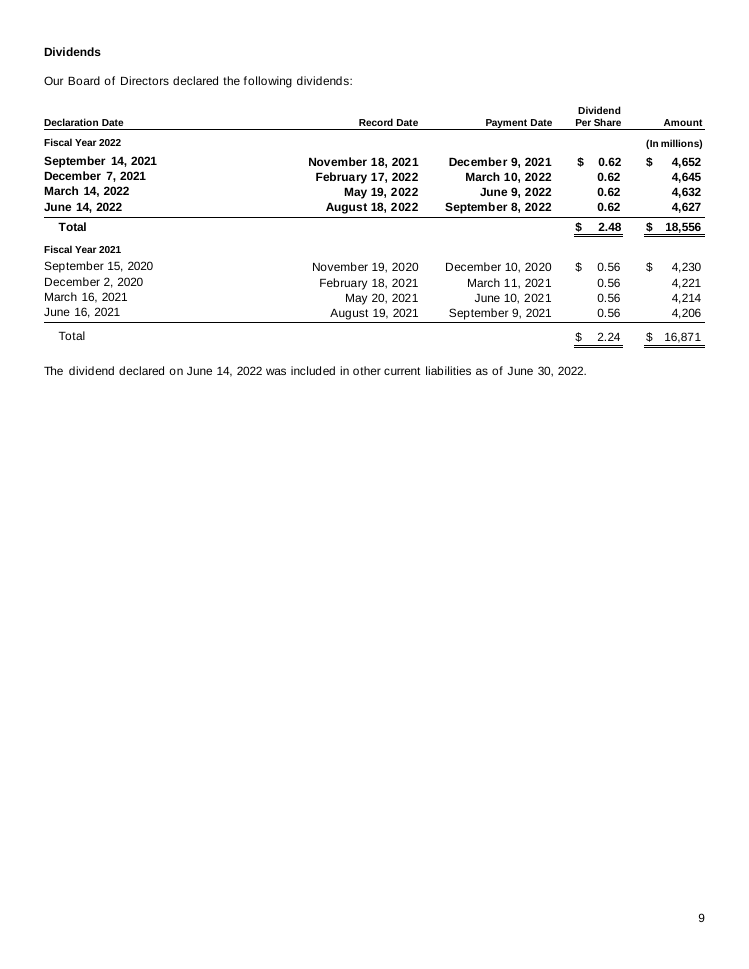

In [47]:
images[0]

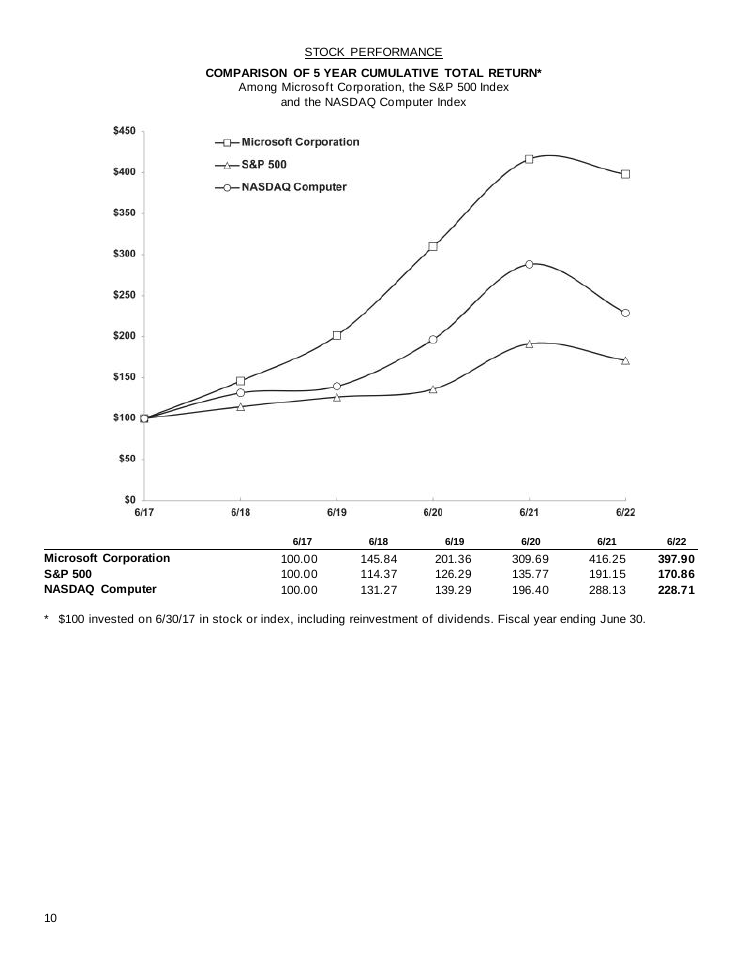

In [48]:
images[1]

## Load Data

In [3]:
loader = PyPDFLoader("ms-financial-statement.pdf")

In [4]:
documents = loader.load_and_split()

In [5]:
len(documents)

2

In [6]:
print(documents[0].page_content)

9   
Dividends  
Our Board of Directors declared the following dividends:  
  
Declaration Date  Record Date  Payment  Date  Dividend  
Per Share  Amount    
          
Fiscal Year 2022        (In millions)  
          
September  14, 2021   November  18, 2021    December  9, 2021   $   0.62  $ 4,652   
December  7, 2021   February  17, 2022    March  10, 2022    0.62   4,645   
March  14, 2022   May 19, 2022    June  9, 2022    0.62   4,632   
June  14, 2022   August  18, 2022    September  8, 2022    0.62   4,627     
Total      $   2.48  $   18,556             
          
Fiscal Year 2021          
          
September  15, 2020   November  19, 2020    December  10, 2020   $ 0.56  $ 4,230   
December  2, 2020   February  18, 2021    March  11, 2021    0.56   4,221   
March  16, 2021   May 20, 2021    June  10, 2021    0.56   4,214   
June  16, 2021   August  19, 2021    September  9, 2021    0.56   4,206     
          
Total      $ 2.24  $ 16,871             
The dividend declared 

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(documents)

In [8]:
len(texts)

3

In [9]:
print(texts[0].page_content)

9   
Dividends  
Our Board of Directors declared the following dividends:  
  
Declaration Date  Record Date  Payment  Date  Dividend  
Per Share  Amount    
          
Fiscal Year 2022        (In millions)  
          
September  14, 2021   November  18, 2021    December  9, 2021   $   0.62  $ 4,652   
December  7, 2021   February  17, 2022    March  10, 2022    0.62   4,645   
March  14, 2022   May 19, 2022    June  9, 2022    0.62   4,632   
June  14, 2022   August  18, 2022    September  8, 2022    0.62   4,627     
Total      $   2.48  $   18,556             
          
Fiscal Year 2021          
          
September  15, 2020   November  19, 2020    December  10, 2020   $ 0.56  $ 4,230   
December  2, 2020   February  18, 2021    March  11, 2021    0.56   4,221   
March  16, 2021   May 20, 2021    June  10, 2021    0.56   4,214   
June  16, 2021   August  19, 2021    September  9, 2021    0.56   4,206     
          
Total      $ 2.24  $ 16,871


## Create Embeddings

In [10]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [11]:
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

## Create Chain

In [12]:
model_n_ctx = 1000
model_path = "./ggml-gpt4all-j-v1.3-groovy.bin"
llm = GPT4All(model=model_path, n_ctx=1000, backend="gptj", verbose=False)

In [13]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True,
    verbose=False,
)

## Ask Questions

In [18]:
%%time
res = qa(
    "How much is the dividend per share during during 2022? Extract it from the text."
)

CPU times: user 7min 48s, sys: 9.76 s, total: 7min 58s
Wall time: 2min 9s


In [19]:
res

{'query': 'How much is the dividend per share during during 2022? Extract it from the text.',
 'result': ' The dividend per share during 2022 is $0.62.',
 'source_documents': [Document(page_content='Total      $ 2.24  $ 16,871             \nThe dividend declared on June  14, 2022 was included in other current liabilities as of June  30, 2022.', metadata={'source': 'ms-financial-statement.pdf', 'page': 0}),
  Document(page_content='9   \nDividends  \nOur Board of Directors declared the following dividends:  \n  \nDeclaration Date  Record Date  Payment  Date  Dividend  \nPer Share  Amount    \n          \nFiscal Year 2022        (In millions)  \n          \nSeptember  14, 2021   November  18, 2021    December  9, 2021   $   0.62  $ 4,652   \nDecember  7, 2021   February  17, 2022    March  10, 2022    0.62   4,645   \nMarch  14, 2022   May 19, 2022    June  9, 2022    0.62   4,632   \nJune  14, 2022   August  18, 2022    September  8, 2022    0.62   4,627     \nTotal      $   2.48  $   1

In [21]:
print(res["result"])

 The dividend per share during 2022 is $0.62.


In [14]:
%%time
prompt = f"""How much is the investment amount in Microsoft on 6/22? Extract the answer from the text."""
res = qa(prompt.strip())

CPU times: user 12min 41s, sys: 9.47 s, total: 12min 51s
Wall time: 3min 29s


In [15]:
print(res["result"])

 The investment amount in Microsoft on 6/22 is $309.69.


## References

- [GPT4All](https://gpt4all.io/)
- [MICROSOFT 2022 ANNUAL REPORT](https://www.microsoft.com/investor/reports/ar22/download-center/)